In [1]:
import numpy as np
import random
import scipy.integrate as scp
import numpy.random as rnd
import time
import matplotlib.pyplot as plt
import numpy.random as rnd
import copy
from matplotlib.pyplot import figure
from pyomo.environ import *
from pyomo.dae import *
import pandas as pd
import pickle
import scipy.stats
from math import comb
from scipy.integrate import odeint

import glob, os

Gneneration of 4 sets of experimental data with different nitrate and light intensity, varies from low to high, number of datapoints for each exps is 17, noise level is 5% of means.

In [2]:
''' Data treatment'''
def save_pkl(item, fname):
    sn = 'data/' + fname
    with open(sn, 'wb') as handle:
        pickle.dump(item, handle) #, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'File saved at: {sn}')
    return None
# return None

def load_pkl(fname):
    with open(fname, 'rb') as handle:
        ans = pickle.load(handle)
    print(f'Loaded from: {fname}')
    return ans

In [3]:
def to_dict(x,dt):
    obs = list(x)
    # tp = list(time)
    dicx = {}
    for i in range(len(x)):
        dicx[dt*i] = obs[i]            # change thye value of 38.4
    return dicx

def get_grad(x, t):
    dxdt = [[],[],[],[]]
    for n in range(x.shape[0]):
        for i in range(len(x[0]) - 1):
            dxdt[n].append((x[n][i + 1] - x[n][i])/(t[i + 1] - t[i]))
        dxdt[n].append(dxdt[n][-1])
    return dxdt


In [4]:
tf    = 16*24
steps_= 10
dt    = tf/steps_ #dt is fixed


num_N = 4
tf_N  = tf/(num_N) # tf_N is fixed
dt_N = 0.2
t_N = np.arange(0,tf_N+dt_N,dt_N)

dstep_N = len(t_N)# this is the number of steps in each interval between chaning the fedding rate

In [5]:
t_simulation = np.arange(0,tf+dt_N,dt_N)

In [6]:
tf/steps_

38.4

In [7]:
t_fn1 = np.arange(0,tf/steps_+dt_N,dt_N)

In [9]:
t_fn1

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
        2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
        4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
        6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
        8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8,
       11. , 11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. ,
       13.2, 13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8, 15. , 15.2,
       15.4, 15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. , 17.2, 17.4,
       17.6, 17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. , 19.2, 19.4, 19.6,
       19.8, 20. , 20.2, 20.4, 20.6, 20.8, 21. , 21.2, 21.4, 21.6, 21.8,
       22. , 22.2, 22.4, 22.6, 22.8, 23. , 23.2, 23.4, 23.6, 23.8, 24. ,
       24.2, 24.4, 24.6, 24.8, 25. , 25.2, 25.4, 25.6, 25.8, 26. , 26.2,
       26.4, 26.6, 26.8, 27. , 27.2, 27.4, 27.6, 27.8, 28. , 28.2, 28.4,
       28.6, 28.8, 29. , 29.2, 29.4, 29.6, 29.8, 30

In [8]:
dt

38.4

In [53]:
t = np.arange(0,tf+dt,dt)

In [54]:
t

array([  0. ,  38.4,  76.8, 115.2, 153.6, 192. , 230.4, 268.8, 307.2,
       345.6, 384. ])

In [55]:
for i in range(len(t)):
    print(t_simulation[(len(t_fn1)-1)*i])

0.0
38.400000000000006
76.80000000000001
115.2
153.60000000000002
192.0
230.4
268.8
307.20000000000005
345.6
384.0


In [56]:
# sobol for 4 experiments, for both N and IT.
from scipy.stats import qmc
sampler = qmc.Sobol(d=2, scramble=False)
sample = sampler.random_base2(m=2)
l_bounds = [0.1,100]   # X,N
u_bounds = [0.2,200]
operation_con = qmc.scale(sample,l_bounds,u_bounds)

In [57]:
operation_con 

array([[1.00e-01, 1.00e+02],
       [1.50e-01, 1.50e+02],
       [1.75e-01, 1.25e+02],
       [1.25e-01, 1.75e+02]])

In [58]:
# # sobol for 16 IT.
# from scipy.stats import qmc
# sampler_I = qmc.Sobol(d=1, scramble=False)
# sample_I = sampler_I.random_base2(m=4)

# l_bounds_I = [50]
# u_bounds_I = [600]
# I_con = qmc.scale(sample_I,l_bounds_I,u_bounds_I)

In [59]:
# sobol for 16 IT. seperate from the initial condition since the feeding concentration of N should not be as high as the initial concentration in the reactor
from scipy.stats import qmc
sampler_N = qmc.Sobol(d=1, scramble=False)
sample_N = sampler_N.random_base2(m=4)

l_bounds_N = [1]
u_bounds_N = [10]
N_con = qmc.scale(sample_N,l_bounds_N,u_bounds_N)

In [60]:
N_con

array([[1.    ],
       [5.5   ],
       [7.75  ],
       [3.25  ],
       [4.375 ],
       [8.875 ],
       [6.625 ],
       [2.125 ],
       [2.6875],
       [7.1875],
       [9.4375],
       [4.9375],
       [3.8125],
       [8.3125],
       [6.0625],
       [1.5625]])

In [61]:
N_con = [N_con[i:i+4] for i in range(0, len(N_con), 4)]

In [62]:
N_con

[array([[1.  ],
        [5.5 ],
        [7.75],
        [3.25]]),
 array([[4.375],
        [8.875],
        [6.625],
        [2.125]]),
 array([[2.6875],
        [7.1875],
        [9.4375],
        [4.9375]]),
 array([[3.8125],
        [8.3125],
        [6.0625],
        [1.5625]])]

In [63]:

# def model(state, t, para):
#     # Internal definitions

    
#     # State vector
#     x = state[0]
#     n = state[1]
#     q = state[2]
#     f = state[3]

#     I0      = para['I0']
    
#     # Parameters

#     kq      = para['kq']
#     ud      = para['ud']
#     un      = para['un']
#     kn      = para['kn']
#     theta   = para['theta']
#     gamma   = para['gamma']
#     epsilon = para['epsilon']
    
#     tau     = para['tau']
#     delta   = para['delta']
#     phi     = para['phi']
#     ks      = para['ks']
#     ki      = para['ki']
#     alpha   = para['alpha']
#     belta   = para['belta']
#     uM      = para['uM']  
    
    
    
#     # Algebraic equations, calculation of um
#         #Initial of L and I
#     L         = 4.4E-2
#     # I0      = 80
#     def I_e(z):

#         I_z   = I0*np.exp(-(alpha*x+belta)*z) 
#         I     = uM*I_z/(I_z+ks+I_z**2/ki)
#         return I





#     um    = scp.quad(I_e, 0, L)
#     um    = um[0]/L


#     u0     = um*(1-kq/q)
    
    
#     # Differential equations
#     dev_x  = u0*x-ud*x
#     dev_n  = -un*(n/(n+kn))*x
#     dev_q  = un*(n/(n+kn)) - (um*(1-(kq/q))-ud)*q
#     dev_f  = um*(theta*q-epsilon*f)*(1-(kq/q)) - gamma*un*(n/(n+kn))+ud*epsilon*f
        
#     # fluorescence
#     Y      = (np.exp(tau*q)/(np.exp(tau*q)+delta))+phi

#     return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64').flatten()


# # Simulation
# def simulation(model, steps, tf, x0,para):
#     t_eval        = np.linspace(0,tf,steps+1)
#     sol           = odeint(model,x0, t_eval, args = (para,)).T
        
#     return sol,t_eval

In [64]:
# # Data generation #
class ModelIntegration:
    '''
    This files integrates the model.
    
     model: this is were the model should be changed 
    '''
    
    # --- initializing model --- #
    def __init__(self, parameters):
        
        # Object variable definitions

        self.parameters = parameters
    # --- dynamic model definition --- #    
    def model(self, t, state):
        # internal definitions
        params = self.parameters
        
        # define controls here

        # state vector
        Cx  = state[0]
        Cn  = state[1]
                # define controls here
        FCn    = params['FCn']
        # print(FCn,'Fcn')
        
        # parameters
        u_m  = params['u_m'] 
        K_N  = params['K_N']
        u_d  = params['u_d']
        Y_nx = params['Y_nx']
        
        # algebraic equations
        
        # variable rate equations
        dev_Cx  = u_m * Cx * Cn/(Cn+K_N) - u_d*Cx**2
        dev_Cn  = - Y_nx * u_m * Cx * Cn/(Cn+K_N) + FCn
        # print("Shape of dev_Cx:", np.shape(dev_Cx))
        # print("Shape of dev_Cn:", np.shape(dev_Cn))
        
        return np.array([dev_Cx, dev_Cn],dtype='float64')
    
    # --- simulation --- #
    def simulation(self, dt, tf, x0):
        '''
        simulate for a number of steps to collect data, and a final time
        '''

        # external definitions
        self.x0, self.tf = x0, tf

        # internal definitions
        model = self.model
        steps    = int(tf/dt)
        
        # compile state trajectories
        xt = np.zeros((x0.shape[0],steps+1))
        tt = np.zeros((steps+1))
        
        # initialize simulation
        current_state = x0
        xt[:,0]       = current_state
        tt[0]         = 0.
        
        # simulation
        for s in range(steps):
            ode           = scp.ode(model)                  # define ode
            ode.set_integrator('lsoda', nsteps=3000)        # define integrator
            ode.set_initial_value(current_state, dt)        # set initial value
            current_state = list(ode.integrate(ode.t + dt)) # integrate system
            xt[:,s+1]     = current_state                   # add current state
            tt[s+1]       = (s+1)*dt
        
        return xt, tt


In [65]:
# class ModelIntegration:

#     # --- initializing model --- #
#     def __init__(self, parameters, controls, tf, x0):

#         # Object variable definitions
#         self.parameters, self.controls = parameters, controls
#         self.x0, self.dt, self.tf      = x0, tf/(controls.shape[1]), tf # change the dt
#         self.u0                        = controls[:,0]

#     # --- dynamic model definition --- #
#     def model(self, t, state):
#         # internal definitions
#         params = self.parameters
#         ctrl   = self.u0

#         # L_I    = ctrl[0]
#         FCn    = ctrl

#         # state vector
#         Cx  = state[0]
#         Cn  = state[1]

        
#         # parameters
#         u_m  = params['u_m'] 
#         K_N  = params['K_N']
#         u_d  = params['u_d']
#         Y_nx = params['Y_nx']
        
        
#         # variable rate equations
#         dev_Cx  = u_m * Cx * Cn/(Cn+K_N) - u_d*Cx**2
#         dev_Cn  = - Y_nx * u_m * Cx * Cn/(Cn+K_N) + FCn
#         # print("Shape of dev_Cx:", np.shape(dev_Cx))
#         # print("Shape of dev_Cn:", np.shape(dev_Cn))
        
#         return np.array([dev_Cx, dev_Cn],dtype='float64')
#     # --- simulation --- #
#     def simulation(self):
#         # internal definitions
#         dt, steps, x0   = self.dt, int(self.tf/float(self.dt)), self.x0
#         model, controls = self.model, self.controls

#         # compile state trajectories
#         xt = np.zeros((x0.shape[0],steps+1))
#         tt = np.zeros((steps+1))

#         # initialize simulation
#         current_state = x0
#         xt[:,0]       = current_state
#         tt[0]         = 0.

#         # simulation
#         for s in range(steps):
#             self.u0   = controls[:,s]                   # control for this step
#             ode       = scp.ode(model)                  # define ode
#             ode.set_integrator('lsoda', nsteps=3000)    # define integrator
#             ode.set_initial_value(current_state,dt)     # set initial value
#             current_state = list(ode.integrate(ode.t + dt)) # integrate system
#             xt[:,s+1]     = current_state                   # add current state
#             tt[s+1]       = (s+1)*dt

#         return xt, tt




In [66]:
def train_data_generation(parameter, initial_c,N_all):
    all_xt = []
    # all_pe = []
    # all_tt = []

    for i in range(len(N_all)):
        parameter['FCn'] = N_all[i]
        print(parameter['FCn'],'FCn')
        m            = ModelIntegration(parameter)
        xt_i, tt_i       = m.simulation(dt_N,tf_N,initial_c) 
        # xt_i, tt_i       = simulation(model, dstep_I,tf_I, initial_c,parameter)
        print(xt_i.shape[1],'xt_i shape')
        all_xt.append(xt_i)
        # all_tt.append(tt_i)
        new_init = np.zeros(2)
        for j in range(2):
            new_init[j] = xt_i[j][-1]
        initial_c = new_init
        # print(initial_c1,'initial_c1')

        # all_pe.append(parameter.copy())

    for i in range(1,len(all_xt)):
        all_xt[i] = np.delete(all_xt[i], 0, axis=1)


        # all_tt[i] = np.delete(all_tt[i], 0, axis=1)
    # print(all_xt,'all_xt')
    xt = all_xt[0]
    # tt = all_tt[0]

    # Iterate through the remaining arrays and concatenate them
    for i in all_xt[1:]:
        xt = np.concatenate((xt, i), axis=1)  # Concatenate along the rows

    
    mean_x = np.zeros(xt.shape[0])
    for i in range(xt.shape[0]):
        mean_x[i]=np.mean(xt[i])
        
    mean_x    = mean_x*0.05
    print(mean_x ,'mean_x')
    std_value = mean_x

    x_noise      = np.random.normal(0,mean_x[0],xt.shape[1])
    x_noise[0]   = 0
    n_noise      = np.random.normal(0,mean_x[1],xt.shape[1])
    n_noise[0]   = 0
    # q_noise      = np.random.normal(0,mean_x[2],xt.shape[1])
    # q_noise[0]   = 0
    # f_noise      = np.random.normal(0,mean_x[3],xt.shape[1])
    # f_noise[0]   = 0 

    obs          = np.array([x_noise,n_noise])
    xobs         = xt+obs

    for i in range(xobs.shape[0]):
        for j in range(len(xobs[i])):
            if xobs[i][j]<0:
                xobs[i][j] = 1E-7
    for i in range(xobs.shape[1]):
        if xobs[0][i]<0:
            xobs[0][i] = 1e-7
        if xobs[1][i]<0:
            xobs[1][i] = 1e-7

    return xt,xobs,std_value

In [67]:
def data_correction(xt,t):
    xt_ = np.zeros([len(t),2])
    for i in range(len(t)):
        # print((len(t_fn1)-1)*i)
        xt_[i] = xt.T[(len(t_fn1)-1)*i]
        # print(xt1_.T[(len(t_fn1)-1)*i])

    xt_ = xt_.T

    return xt_

In [68]:
#experiment 1

p1  = {'u_m' : 0.0923*0.62, 'K_N' : 393.10, 'u_d' : 0.01, 'Y_nx' : 504.49,'FCn':N_con[0][0]}
initial_c1 =  operation_con[0]

xt1_,xobs1_,std_value1 = train_data_generation(p1, initial_c1,N_con[0])


[1.] FCn
481 xt_i shape
[5.5] FCn
481 xt_i shape
[7.75] FCn


C:\Users\wangh\AppData\Local\Temp\ipykernel_14848\214994354.py:43: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_Cx, dev_Cn],dtype='float64')


481 xt_i shape
[3.25] FCn
481 xt_i shape
[0.0359745  5.94262293] mean_x


In [69]:
xt1 = data_correction(xt1_,t)
xobs1 = data_correction(xobs1_,t)

In [70]:
#experiment 2

p2  = {'u_m' : 0.0923*0.62, 'K_N' : 393.10, 'u_d' : 0.01, 'Y_nx' : 504.49,'FCn':N_con[1][0]}
initial_c2 =  operation_con[1]

xt2_,xobs2_,std_value2 = train_data_generation(p2, initial_c2,N_con[1])


[4.375] FCn
481 xt_i shape
[8.875] FCn
481 xt_i shape
[6.625] FCn
481 xt_i shape
[2.125] FCn


C:\Users\wangh\AppData\Local\Temp\ipykernel_14848\214994354.py:43: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_Cx, dev_Cn],dtype='float64')


481 xt_i shape
[0.04620039 6.58138425] mean_x


In [71]:
xt2 = data_correction(xt2_,t)
xobs2 = data_correction(xobs2_,t)

In [72]:
#experiment 3

p3  = {'u_m' : 0.0923*0.62, 'K_N' : 393.10, 'u_d' : 0.01, 'Y_nx' : 504.49,'FCn':N_con[2][0]}
initial_c3 =  operation_con[2]

xt3_,xobs3_,std_value3 = train_data_generation(p3, initial_c3,N_con[2])

[2.6875] FCn
481 xt_i shape
[7.1875] FCn
481 xt_i shape
[9.4375] FCn


C:\Users\wangh\AppData\Local\Temp\ipykernel_14848\214994354.py:43: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_Cx, dev_Cn],dtype='float64')


481 xt_i shape
[4.9375] FCn
481 xt_i shape
[0.04615393 6.41428602] mean_x


In [73]:
xt3 = data_correction(xt3_,t)
xobs3 = data_correction(xobs3_,t)

In [74]:
#experiment 4

p4  = {'u_m' : 0.0923*0.62, 'K_N' : 393.10, 'u_d' : 0.01, 'Y_nx' : 504.49,'FCn':N_con[3][0]}
initial_c4 =  operation_con[3]

xt4_,xobs4_,std_value4 = train_data_generation(p4, initial_c4,N_con[3])

[3.8125] FCn
481 xt_i shape
[8.3125] FCn
481 xt_i shape
[6.0625] FCn


C:\Users\wangh\AppData\Local\Temp\ipykernel_14848\214994354.py:43: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_Cx, dev_Cn],dtype='float64')


481 xt_i shape
[1.5625] FCn
481 xt_i shape
[0.04387793 6.55825355] mean_x


In [75]:
xt4 = data_correction(xt4_,t)
xobs4 = data_correction(xobs4_,t)

In [76]:
def plot_data(x, y1,y2,name):
    fig = plt.figure()
    plt.plot(x, y1,'.')
    plt.plot(x, y2, '-',label=name)
    plt.ylabel('State')
    plt.xlabel('Time')
    plt.legend(loc="lower right")
    fig.savefig(name)
    plt.show()
    return None
def check_plot(xobs,xt,tt):
    plot_data(tt, xobs[0],xt[0],'biomass')
    plot_data(tt, xobs[1],xt[1],'nitrate')
    plot_data(tt, xobs[2],xt[2],'quota')
    plot_data(tt, xobs[3],xt[3],'fame')
    return None

In [77]:
def plot_data(x, y1,y2):
    fig = plt.figure()
    plt.plot(x, y1,'.',color = 'red')
    # plt.plot(x, y1hat,'.',color = 'blue')
    plt.plot(x, y2, '-')
    # plt.plot(x, y2hat, '-',label=namehat)
    plt.ylabel('State')
    plt.xlabel('Time')
    # plt.legend(loc="lower right")
    # fig.savefig(name)
    plt.show()
    return None
def check_plot(xobs,xt,tt):
    plot_data(tt, xobs[0],xt[0])
    plot_data(tt, xobs[1],xt[1])

    return None

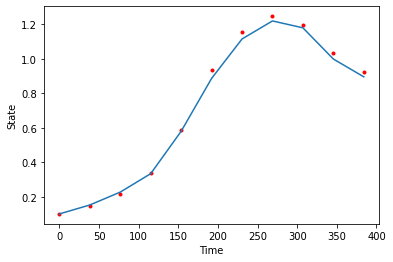

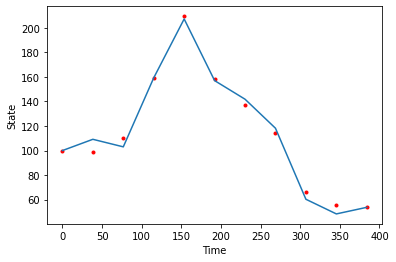

In [78]:
check_plot(xobs1,xt1,t)

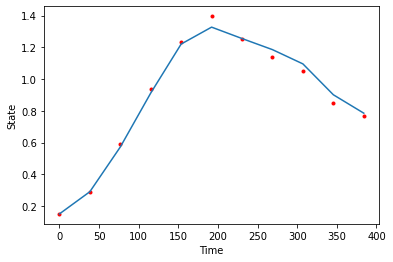

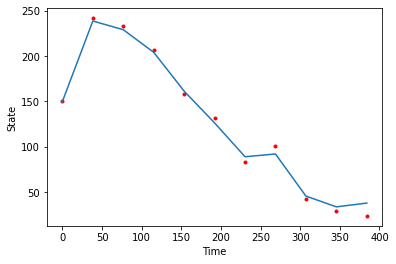

In [79]:
check_plot(xobs2,xt2,t)

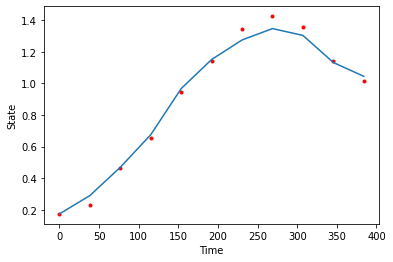

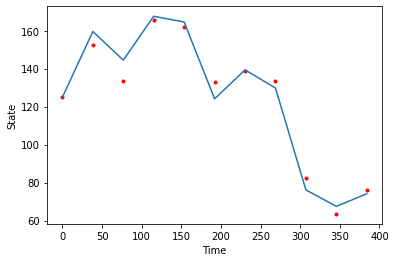

In [80]:
check_plot(xobs3,xt3,t)

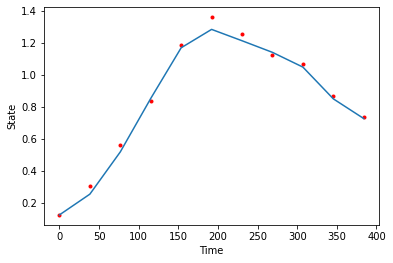

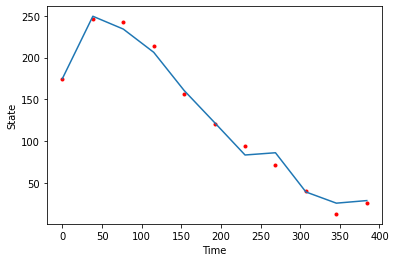

In [81]:
check_plot(xobs4,xt4,t)

In [82]:
t

array([  0. ,  38.4,  76.8, 115.2, 153.6, 192. , 230.4, 268.8, 307.2,
       345.6, 384. ])

In [83]:
data_init   = {None: dict(t       = {None: list(t)},
                          tm      = {None: list(t)},
                          x1_noise = to_dict(xobs1[0],dt),
                          n1_noise = to_dict(xobs1[1],dt),
                          x2_noise = to_dict(xobs2[0],dt),
                          n2_noise = to_dict(xobs2[1],dt),
                          x3_noise = to_dict(xobs3[0],dt),
                          n3_noise = to_dict(xobs3[1],dt),
                          x4_noise = to_dict(xobs4[0],dt),
                          n4_noise = to_dict(xobs4[1],dt))}

In [84]:
data_init

{None: {'t': {None: [0.0,
    38.4,
    76.8,
    115.19999999999999,
    153.6,
    192.0,
    230.39999999999998,
    268.8,
    307.2,
    345.59999999999997,
    384.0]},
  'tm': {None: [0.0,
    38.4,
    76.8,
    115.19999999999999,
    153.6,
    192.0,
    230.39999999999998,
    268.8,
    307.2,
    345.59999999999997,
    384.0]},
  'x1_noise': {0.0: 0.1,
   38.4: 0.14412258471802736,
   76.8: 0.21289170650288047,
   115.19999999999999: 0.3368549509060771,
   153.6: 0.5877540822232143,
   192.0: 0.9321577113794461,
   230.39999999999998: 1.1555354342924982,
   268.8: 1.2460362857444118,
   307.2: 1.1945426866299533,
   345.59999999999997: 1.032472350803414,
   384.0: 0.9205285575272696},
  'n1_noise': {0.0: 100.0,
   38.4: 99.01797414219256,
   76.8: 110.17765465841524,
   115.19999999999999: 159.27152940460482,
   153.6: 209.5013431512246,
   192.0: 158.61667642695116,
   230.39999999999998: 136.81072714420583,
   268.8: 114.12493988346515,
   307.2: 66.0556833720789,
   3

In [85]:
operation_con[0]

array([  0.1, 100. ])

In [86]:
operation_con

array([[1.00e-01, 1.00e+02],
       [1.50e-01, 1.50e+02],
       [1.75e-01, 1.25e+02],
       [1.25e-01, 1.75e+02]])

In [87]:
save_pkl(xobs1,'xobs1.pkl')
save_pkl(xobs2,'xobs2.pkl')
save_pkl(xobs3,'xobs3.pkl')
save_pkl(xobs4,'xobs4.pkl')
save_pkl(N_con,'Fcn.pkl')
save_pkl(tf_N,'tf_N.pkl')
save_pkl(operation_con,'operation_con.pkl')
# save_pkl(I0_range,'I0_range.pkl')

save_pkl(t,'tt1.pkl')
save_pkl(std_value1,'std_value1.pkl')
save_pkl(std_value2,'std_value2.pkl')
save_pkl(std_value3,'std_value3.pkl')
save_pkl(std_value4,'std_value4.pkl')

save_pkl(data_init,'data_init.pkl')


File saved at: data/xobs1.pkl
File saved at: data/xobs2.pkl
File saved at: data/xobs3.pkl
File saved at: data/xobs4.pkl
File saved at: data/Fcn.pkl
File saved at: data/tf_N.pkl
File saved at: data/operation_con.pkl
File saved at: data/tt1.pkl
File saved at: data/std_value1.pkl
File saved at: data/std_value2.pkl
File saved at: data/std_value3.pkl
File saved at: data/std_value4.pkl
File saved at: data/data_init.pkl


In [88]:
tf_N

96.0